In [1]:
%pylab inline
import pandas as pd
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir -p ../input

In [3]:
os.chdir('..')

In [4]:
!ls input

FASTA	       ncbi_taxonomy_accession2taxid  nt_head.txt.small.zst
FASTA.zip      ncbi_taxonomy.tar	      nt_seq.txt
info	       nt.gz			      nt_seq.txt.small.zst
ncbi_taxonomy  nt_head.txt		      task


In [5]:
#!cd input && rm -fr ncbi_taxonomy &&  cat /mnt/lizhen-notebook/cami2/ncbi_taxonomy.tar | tar x && cd ncbi_taxonomy/ && tar xf taxdump.tar.gz && unzip taxcat.zip

In [6]:
names = pd.read_csv("input/ncbi_taxonomy/names.dmp",sep='|', header=None)
for i in range(1,4):
    names[i]=names[i].map(lambda u: u.strip())
names.columns=['tax_id','name_text','unique_name','name_class','na']  
mynames=dict(names.loc[names['name_class']=='scientific name',['tax_id','name_text']].values)
def get_names(tax_id):
    return mynames[tax_id]

In [7]:
names[names['tax_id']==1834200]

Empty DataFrame
Columns: [tax_id, name_text, unique_name, name_class, na]
Index: []

In [8]:
names.head()

tax_id    name_text             unique_name       name_class  na
0       1          all                                  synonym NaN
1       1         root                          scientific name NaN
2       2     Bacteria  Bacteria <prokaryotes>  scientific name NaN
3       2       Monera       Monera <Bacteria>          in-part NaN
4       2  Procaryotae  Procaryotae <Bacteria>          in-part NaN

In [9]:
pd.Series(mynames).to_frame().head()

0
1                      root
2                  Bacteria
6              Azorhizobium
7  Azorhizobium caulinodans
9       Buchnera aphidicola

In [10]:
get_names(2)

'Bacteria'

In [11]:
nodes = pd.read_csv("input/ncbi_taxonomy/nodes.dmp",sep='|', header=None)
nodes.columns=['tax_id','parent_id','rank','embl','division','dv_flag','gen_code_id','gc_flag','mit_code','mgc_code','genbank_hidflag','hid_flag','comments','na']
for u in ['rank','comments','embl']:
    nodes[u]=nodes[u].map(lambda u: u.strip())
ranks=set(['root','superkingdom', 'kingdom', 'phylum','class','order','family','genus','species'])
#unwanted_ids=set([ u for u in nodes[~nodes['rank'].isin(ranks)].tax_id if u<>1])
#len(unwanted_ids), 1 in unwanted_ids    

In [12]:
nodes[nodes['tax_id']==1834200]

Empty DataFrame
Columns: [tax_id, parent_id, rank, embl, division, dv_flag, gen_code_id, gc_flag, mit_code, mgc_code, genbank_hidflag, hid_flag, comments, na]
Index: []

In [13]:
nodes.head()

tax_id  parent_id          rank embl  division  dv_flag  gen_code_id  \
0       1          1       no rank              8        0            1   
1       2     131567  superkingdom              0        0           11   
2       6     335928         genus              0        1           11   
3       7          6       species   AC         0        1           11   
4       9      32199       species   BA         0        1           11   

   gc_flag  mit_code  mgc_code  genbank_hidflag  hid_flag comments  na  
0        0         0         0                0         0          NaN  
1        0         0         0                0         0          NaN  
2        1         0         1                0         0          NaN  
3        1         0         1                1         0          NaN  
4        1         0         1                1         0          NaN

In [14]:
rank_map=dict(nodes[['tax_id','rank']].values)

In [15]:
import pickle
#pickle.dump(merged_map,open('input/merged_tax_map.pkl','wb'))
#!cp input/merged_tax_map.pkl /mnt/lizhen-notebook/cami2/

In [16]:
class Node(object):
    def __init__(self,nid, rank, name):
        self.nid,self.rank,self.name=nid, rank, name
        self.children=set([])
        self.parent_id = None
    def set_parent(self,pid):
        if self.nid==1:
            pass
        elif self.parent_id is None or self.parent_id==pid:
            self.parent_id=pid
        else:
            raise Exception("ERROR2: {} {}".format(pid,parent_id))
    def is_root(self):
        return self.parent_id is None
    
    def is_child(self):
        return len(self.children)==0
    
    def add_child(self,cid):
        if cid==1 and self.nid==1:
            pass
        else:
            assert cid<>self.nid
            self.children.add(cid)
        
    def __repr__(self):
        return str([self.nid,self.rank,self.name,self.children, self.parent_id])
class Tree(object):
    def __init__(self):
        self.nodes={}
        self.root=None
    def add_node(self,nid, rank, name):
        node=Node(nid, rank, name)
        if node.is_root():
            if self.root is None and nid==1:
                self.root=node
            else:
                pass
                #raise Exception("ERROR2: {} {}".format(nid,rank))
        self.nodes[node.nid]=node
    def get_node(self,nid):
        return self.nodes[nid]
    
    def get_parent(self,nid):
        return self.get_node(nid).parent_id
    
    def get_children(self,nid):
        return get_node(nid).children
    
    def valid(self):
        assert self.root is not None
        for nid in self.nodes:
            if nid<>1:
                assert self.get_parent(nid) is not None
    def remove_node(self,nid):
        assert nid<> self.root.nid
        node = self.get_node(nid)
        del self.nodes[nid]
        
        pid = node.parent_id
        assert nid <> pid
        children = node.children
        assert pid in self.nodes, str([nid,pid])
        self.get_node(pid).children={u for u in self.get_node(pid).children if u<> nid}
        for cid in children:
            assert cid in self.nodes, str([nid,cid])
            self.get_node(cid).parent_id=pid
            self.get_node(pid).children.add(cid)
    def num_sub_nodes(self,nid):
        cnt=0
        node = self.get_node(nid)
        children = node.children
        for cid in children:
            if cid <>1:
                cnt+=1
                cnt+=num_sub_nodes(self,cid)
        return cnt            

In [17]:
tree=Tree()
for a in nodes[['tax_id','parent_id', 'rank']].values:
    #print list(a)
    tree.add_node(a[0],a[2],get_names(a[0]))
for a in nodes[['tax_id','parent_id']].values:
    #print list(a)
    node=tree.get_node(a[0])
    node.set_parent(a[1])
    node=tree.get_node(a[1])
    node.add_child(a[0])
tree.root=tree.get_node(1)

In [18]:
tree.valid()

In [19]:
tree.root

[1, 'no rank', 'root', set([28384, 12908, 131567, 12884, 10239]), None]

In [20]:
len(tree.nodes)

2043416

In [21]:
sum([u.is_child() for u in tree.nodes.values()])

1895219

In [22]:
sum([len(u.children)==1 for u in tree.nodes.values()])

63238

In [23]:
sum([len(u.children)==0 for u in tree.nodes.values()])

1895219

In [24]:
sum([len(u.children)==2 for u in tree.nodes.values()])

24758

In [25]:
log2(1895219),log2(295219)

(20.853933136432207, 18.171426049235116)

In [26]:
cl = np.array([len(u.children) for u in tree.nodes.values()])
cl=cl[cl>0]

In [27]:
np.max(cl),np.min(cl)

(42469, 1)

In [28]:
max(tree.nodes.keys())

2501463

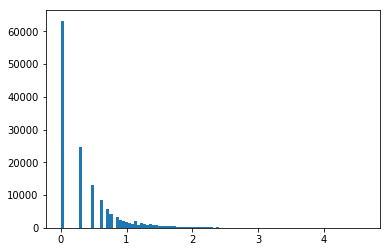

In [29]:
plt.hist(np.log10(cl),bins=100);

In [30]:
bignodes = [u for u   in tree.nodes.values() if len(u.children)>1000]
len(bignodes)

179

In [31]:
def create_fqnode(nid,parent,left,right,count,binary,name=None,rank=None):
    return {u: v for u,v in locals().items()}

In [32]:
create_fqnode(1,1,2,3,23,0)

{'binary': 0,
 'count': 23,
 'left': 2,
 'name': None,
 'nid': 1,
 'parent': 1,
 'rank': None,
 'right': 3}

In [33]:
import json

In [34]:
json.dumps(create_fqnode(1,1,2,3,23,0)),json.dumps(create_fqnode(1,None,2,3,23,0))

('{"count": 23, "binary": 0, "right": 3, "name": null, "parent": 1, "rank": null, "nid": 1, "left": 2}',
 '{"count": 23, "binary": 0, "right": 3, "name": null, "parent": null, "rank": null, "nid": 1, "left": 2}')

In [35]:
dummy_node=3000000
idx=0
allnodes={}
allfqnodes=[]
def create_dummynode(pid):
    global dummy_node
    dummynode1 = Node(nid=dummy_node, rank="dummy", name="dummy"+str(dummy_node))
    dummynode1.set_parent(pid)
    dummy_node+=1
    return dummynode1

def search(nid,pid=None):
    global idx
    idx+=1
    #if idx>100: return
    node= allnodes[nid] if nid in allnodes else tree.nodes[nid]
    children=list(node.children)
    if(len(children)==0):
        #assert False, "should not be here"
        fqnode = create_fqnode(nid, parent=pid,left=-1,right=-1,count=100,binary=False, rank=node.rank,name=node.name)
        allfqnodes.append(fqnode)

    elif (len(children)==1):
        left = tree.nodes[children[0]]
        #right=create_dummynode(nid)
        
        allnodes[left.nid]=left
        #allnodes[right.nid]=right
        
        search(children[0],nid)
        
        fqnode = create_fqnode(nid, parent=pid,left=left.nid,right=-1,count=100,binary=True, rank=node.rank,name=node.name)
        allfqnodes.append(fqnode)

    elif (len(children)==2):   
        left = tree.nodes[children[0]]
        right = tree.nodes[children[1]]
        
        allnodes[left.nid]=left
        allnodes[right.nid]=right
        
        search(children[0],nid)
        search(children[1],nid)

        fqnode = create_fqnode(nid, parent=pid,left=left.nid,right=right.nid,count=100,binary=True, rank=node.rank,name=node.name)
        allnodes[left.nid]=left
        allnodes[right.nid]=right
        allfqnodes.append(fqnode)

    else:
        k = int(len(children)/2)
        
        dummynode1 = create_dummynode(nid)
        for u in children[:k]: dummynode1.add_child(u)

        dummynode2 = create_dummynode(nid)
        for u in children[k:]: dummynode2.add_child(u)
        allnodes[dummynode1.nid]=dummynode1
        allnodes[dummynode2.nid]=dummynode2

        search(dummynode1.nid,nid)
        search(dummynode2.nid,nid)
        
        fqnode = create_fqnode(nid, parent=pid,left=dummynode1.nid,right=dummynode2.nid,count=100,binary=True, rank=node.rank,name=node.name)
        allfqnodes.append(fqnode)        


In [36]:
%time search(1)

CPU times: user 44.5 s, sys: 2.06 s, total: 46.6 s
Wall time: 46.5 s


In [37]:
len(allnodes)

4188863

In [38]:
tree.nodes[1]

[1, 'no rank', 'root', set([28384, 12908, 131567, 12884, 10239]), None]

In [39]:
set([u['nid'] for u in allfqnodes]).difference(set([u.nid for u in allnodes.values()]))

{1}

In [40]:
allfqnodes[4000]

{'binary': True,
 'count': 100,
 'left': 3002222,
 'name': 'dummy3002195',
 'nid': 3002195,
 'parent': 3002192,
 'rank': 'dummy',
 'right': 3002223}

In [41]:
fqnodesmap={u['nid']:u for u in allfqnodes}
len(fqnodesmap)

4188864

In [42]:
fqnodesmap[1]

{'binary': True,
 'count': 100,
 'left': 3000000,
 'name': 'root',
 'nid': 1,
 'parent': None,
 'rank': 'no rank',
 'right': 3000001}

In [ ]:
paths={}
def get_path(nid):
    if nid in paths:
        return paths[nid]
    node = fqnodesmap[nid]
    pid=node['parent']
    if pid is None:
        pass
    else:
        pnode = fqnodesmap[pid]
        if nid == pnode['left']:
            code = True
        elif nid == pnode['right']:
            code=False
        else:
            raise Exception("something wrong")
            
        p = get_path(pid) +[pid]
        paths[nid]=p
        return p
paths[1]=[]        
for nid in fqnodesmap:
    get_path(nid)
node_paths=paths    

In [ ]:
node_paths={}
code_paths={}
name_paths={}
paths={}
def get_path(nid):
    if nid in paths:
        return paths[nid]
    node = fqnodesmap[nid]
    pid=node['parent']
    if pid is None:
        pass
    else:
        pnode = fqnodesmap[pid]
        if nid == pnode['left']:
            code = True
        elif nid == pnode['right']:
            code=False
        else:
            raise Exception("something wrong")
            
        p = get_path(pid) +[(pid,code,pnode['name'])]
        paths[nid]=p
        return p
paths[1]=[]        
for nid in fqnodesmap:
    get_path(nid)

In [106]:
len(paths)

4188864

In [116]:
paths[1]

[]

In [117]:
paths[2]

[(1, False, 'root'),
 (3000001, False, 'dummy3000001'),
 (3019651, False, 'dummy3019651'),
 (131567, True, 'cellular organisms'),
 (3234078, True, 'dummy3234078')]

In [ ]:
node_paths = {}
for k in paths:
    node_paths[k]= [u[0] for u in paths[k]]
len(node_paths)    

In [121]:
pd.DataFrame(paths[741158])

0      1                     2
0         1  False                  root
1   3000001  False          dummy3000001
2   3019651  False          dummy3019651
3    131567  False    cellular organisms
4   3234079  False          dummy3234079
5      2759   True             Eukaryota
6   3798566   True          dummy3798566
7   3798568   True          dummy3798568
8   3798570  False          dummy3798570
9   3798573   True          dummy3798573
10    33154  False          Opisthokonta
11  3798631   True          dummy3798631
12  3965184  False          dummy3965184
13    33208   True               Metazoa
14  3965186  False          dummy3965186
15     6072  False             Eumetazoa
16  3968485  False          dummy3968485
17    33213   True             Bilateria
18  3977190   True          dummy3977190
19  3977192   True          dummy3977192
20    33511  False         Deuterostomia
21  3977195  False          dummy3977195
22     7711   True              Chordata
23  3980750  False          dummy3980750
24    89593   True              Craniata
25     7742   True            Vertebrata
26  3981316   True          dummy3981316
27     7776  False         Gnathostomata
28   117570   True            Teleostomi
29   117571  False          Euteleostomi
30     8287  False         Sarcopterygii
31  1338369   True  Dipnotetrapodomorpha
32    32523   True             Tetrapoda
33    32524  False               Amniota
34    40674  False              Mammalia
35  4040345   True          dummy4040345
36    32525   True                Theria
37     9347  False              Eutheria
38  4040351   True          dummy4040351
39  4040354   True          dummy4040354
40  1437010  False         Boreoeutheria
41   314146  False      Euarchontoglires
42  4044101  False          dummy4044101
43     9443   True              Primates
44  4047770   True          dummy4047770
45   376913  False           Haplorrhini
46   314293   True           Simiiformes
47     9526  False            Catarrhini
48   314295  False            Hominoidea
49     9604  False             Hominidae
50   207598  False             Homininae
51  4048031  False          dummy4048031
52     9605  False                  Homo
53     9606  False          Homo sapiens

In [120]:
pd.DataFrame(paths[543])

0      1                    2
0         1  False                 root
1   3000001  False         dummy3000001
2   3019651  False         dummy3019651
3    131567   True   cellular organisms
4   3234078   True         dummy3234078
5         2   True             Bacteria
6   3234080  False         dummy3234080
7   3234083   True         dummy3234083
8   3234944   True         dummy3234944
9   3234946   True         dummy3234946
10     1224  False       Proteobacteria
11  3234949  False         dummy3234949
12  3236885  False         dummy3236885
13  3244539  False         dummy3244539
14     1236  False  Gammaproteobacteria
15  3340569  False         dummy3340569
16  3357417  False         dummy3357417
17  3392893  False         dummy3392893
18  3398781   True         dummy3398781
19    91347  False     Enterobacterales
20  3441841  False         dummy3441841
21  3450841  False         dummy3450841
22  3450861  False         dummy3450861

In [115]:
pd.DataFrame(paths[1006004])

0      1                      2
0         1  False                   root
1   3000001  False           dummy3000001
2   3019651  False           dummy3019651
3    131567   True     cellular organisms
4   3234078   True           dummy3234078
5         2   True               Bacteria
6   3234080  False           dummy3234080
7   3234083   True           dummy3234083
8   3234944   True           dummy3234944
9   3234946   True           dummy3234946
10     1224  False         Proteobacteria
11  3234949  False           dummy3234949
12  3236885  False           dummy3236885
13  3244539  False           dummy3244539
14     1236  False    Gammaproteobacteria
15  3340569  False           dummy3340569
16  3357417  False           dummy3357417
17  3392893  False           dummy3392893
18  3398781   True           dummy3398781
19    91347  False       Enterobacterales
20  3441841  False           dummy3441841
21  3450841  False           dummy3450841
22  3450861  False           dummy3450861
23      543  False     Enterobacteriaceae
24  3450979   True           dummy3450979
25  3468172   True           dummy3468172
26  3468174   True           dummy3468174
27  3468176   True           dummy3468176
28  3468178   True           dummy3468178
29    82976   True           Buttiauxella
30  3468180   True           dummy3468180
31  3468182  False           dummy3468182
32  3468185   True           dummy3468185
33  3468200   True           dummy3468200
34  3468202   True           dummy3468202
35  3468204   True           dummy3468204
36    82977   True  Buttiauxella agrestis

In [91]:
np.sum([ u['binary'] for u in allfqnodes ])

2293645

In [93]:
np.sum([ not u['binary'] for u in allfqnodes ])

1895219